In [ ]:
'''
小鱼儿老师：课程13-编写强化学习环境 https://space.bilibili.com/1074027633/channel/collectiondetail?sid=1433745
'''

In [2]:
import numpy as np
import cv2
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import time
import os
from matplotlib import style
style.use('ggplot')

In [16]:
# 初始化环境参数
SIZE = 10
EPISODES = 30000
SHOW_EVERY = 3000

FOOD_REWARD = 25 #食物奖励
ENEMY_PENALITY = 300 #敌人惩罚
MOVE_PENALITY = 1 #移动惩罚

epsilon = 0.6 #选择随机概率
EPS_DECAY = 0.9998 #概率折扣

DISCOUNT = 0.95 #折扣 gamma
LEARNING_RATE = 0.3 #alpha

q_table = 'Q_table\qtable_1720083453.pickle'

d = {1:(255, 0, 0), # red
     2:(0, 255, 0), # green
     3:(0, 0, 255)} #bule

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3


In [10]:
# 方格类：可实现为玩家、食物、敌人
class Cube:
    def __init__(self):
        self.x = np.random.randint(0,SIZE)
        self.y = np.random.randint(0,SIZE)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self, other):
        return (self.x-other.x,self.y-other.y)
    
    # 1:向左或向下，2：不动，3：向右或向上
    def action(self, choise):
        if choise == 0:
            self.move(x=2, y=2)
        elif choise == 1:
            self.move(x=3, y=2)
        elif choise == 2:
            self.move(x=2, y=3)
        elif choise == 3:
            self.move(x=2, y=1)
        elif choise == 4:
            self.move(x=1, y=2)
    
    def move(self, x=False, y=False):
        if not x:
            self.x = self.x + np.random.randint(-1, 2)
        else:
            self.x = self.x + x - 2
        if not y:
            self.y = self.y + np.random.randint(-1, 2) 
        else:
         self.y = self.y + y -2
            
            
        #边界情况
        if self.x < 0:
            self.x = 0
        if self.x >= SIZE:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        if self.y >= SIZE:
            self.y = SIZE-1

In [17]:
# Cube Test
player = Cube()
print(player)
player.action(4)
print(player)
# food = Cube()
# print(food)
# print(player-food)


6,5
5,5


In [12]:
q_table = None
epsilon = 0.6 #选择随机概率

In [18]:
# 初始化q_table
if q_table is None:
    q_table = {}
    
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[(x1, y1),(x2, y2)] = [np.random.uniform(-5, 0) for i in range(5)]
                    
else:
    with open(q_table, 'rb') as f:
        q_table = pickle.load(f)

episode #3000, epsilon:0.32926722239570905
mean reward:-62.67033333333333
episode #6000, epsilon:0.18069483957364205
mean reward:-41.856
episode #9000, epsilon:0.09916147987941909
mean reward:-34.06466666666667
episode #12000, epsilon:0.054417708414240505
mean reward:-36.99366666666667
episode #15000, epsilon:0.029863279497827713
mean reward:-33.24366666666667
episode #18000, epsilon:0.016388331819794114
mean reward:-30.326333333333334
episode #21000, epsilon:0.00899356749667138
mean reward:-31.741333333333333
episode #24000, epsilon:0.00493547831509555
mean reward:-29.248666666666665
episode #27000, epsilon:0.0027084853933429503
mean reward:-28.405
27001


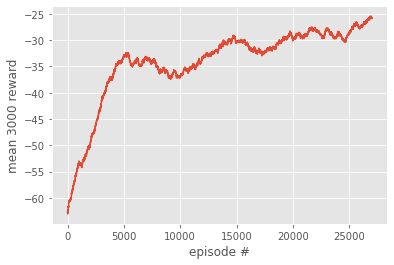

In [19]:
#train
episode_rewards = []
for episode in range(EPISODES):
    # 实例化player \ food \ enemy
    player = Cube()
    food = Cube()
    enemy = Cube()
    
    # 显示图像 
    if(episode % SHOW_EVERY == 0 and episode >= SHOW_EVERY):
        print(f'episode #{episode}, epsilon:{epsilon}')
        print(f'mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}')
        flag_show = True
    else:
        flag_show = False
    
    episode_reward = 0
    for i in range(200):
        obs = (player - food, player - enemy)
        
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs]) #选择Q值最高动作
        else:
            action = np.random.randint(0, 5) #随机选择一个动作
            
        player.action(action)
        # TODO : move

        # 奖励
        if(player.x == food.x and player.y == food.y):
            reward = FOOD_REWARD
        elif(player.x == enemy.x and player.y == enemy.y):
            reward = -ENEMY_PENALITY
        else:
            reward = -MOVE_PENALITY
        
        # Update the Q_table
        current_q = q_table[obs][action]
        new_obs = (player - food, player - enemy)
        max_future_q = np.max(q_table[new_obs])
        
        if(reward == FOOD_REWARD):#TODO: ?为什么不考虑reward == -ENEMY_PENALITY 的情况
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT + max_future_q) 
        q_table[obs][action] = new_q
        
        if flag_show:
            env = np.zeros((SIZE, SIZE, 3), dtype = np.uint8)
            env[food.x][food.y] = d[FOOD_N]
            env[player.x][player.y] = d[PLAYER_N]
            env[enemy.x][enemy.y] = d[ENEMY_N]
            
            img = Image.fromarray(env, 'RGB')
            img = img.resize((800, 800))

            cv2.imshow('', np.array(img))
            
            if (reward == FOOD_REWARD or reward == -ENEMY_PENALITY):
                if cv2.waitKey(5000) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        
        
        episode_reward += reward
        
        # 吃到food
        if (reward == FOOD_REWARD or reward == -ENEMY_PENALITY):
            break
            
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
    
cv2.destroyAllWindows()
#画曲线
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode = 'valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()



In [20]:
if not os.path.exists('Q_table'):
    os.makedirs('Q_table')
with open(f'Q_table\qtable_{int(time.time())}.pickle', 'wb') as f:
    pickle.dump(q_table, f)

27001


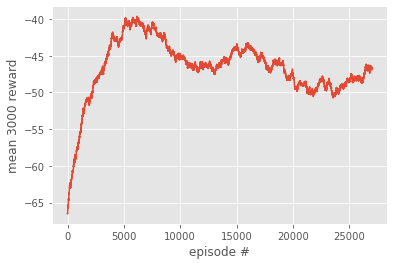

In [ ]:
#画曲线
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode = 'valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

In [ ]:
# 显示界面
food = Cube()
player = Cube()
enemy = Cube()

env = np.zeros((SIZE, SIZE, 3), dtype = np.uint8)
env[food.x][food.y] = d[FOOD_N]
env[player.x][player.y] = d[PLAYER_N]
env[enemy.x][enemy.y] = d[ENEMY_N]

img = Image.fromarray(env, 'RGB')
img = img.resize((800, 800))

cv2.imshow('', np.array(img))

if cv2.waitKey(5000) & 0xFF == ord('q'):
    pass
cv2.destroyAllWindows()

In [ ]:
# test cv关闭所有窗口
cv2.destroyAllWindows()

In [ ]:
conv = np.convolve([2,3,5,8,12,34,67,89], np.ones((3,))/3, mode = 'valid')